In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Class PolynomialFeatures
class PolynomialFeatures:
    def __init__(self, degree):
        self.degree = degree

    def fit_transform(self, X):
        n = X.shape[1]
        for i in range(2, self.degree + 1):  # Commencer à i=2 pour avoir des puissances au-dessus de 1
            for j in range(n):
                X = np.hstack((X, (X[:, j] ** i).reshape((-1, 1))))  # Ajouter les puissances de chaque feature
        return X


class Regression:
    def __init__(self, learning_rate=0.01, iterations=1000, degree=1, test_size=0.2, random_state=42):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.degree = degree
        self.test_size = test_size
        self.random_state = random_state
      
        self.X_train=None
        self.X_test=None
        self.y_train=None
        self.y_test=None
        # Calcule Moyenne et Ecart-type pour chaque variable (on en a besoin plus tard)
        self.X_train_mean = None 
        self.X_train_std = None
        self.y_train_mean = None 
        self.y_train_std = None 
        self.theta = None
    
    def standardize(self, X):
      """ Standardiser les données (calculer les moyennes et écarts-types et appliquer la normalisation). """
      if X.ndim == 1:
          X = X.reshape(-1, 1)  # Convert 1D array to 2D
      mean = np.mean(X, axis=0)
      std = np.std(X, axis=0)
      std[std == 0] = 1e-8  # Avoid division by zero
      return (X - mean) / std , mean , std

    def transform_polynomial(self, X):
        """ Appliquer la transformation polynomiale. """
        if self.degree > 1:
            poly = PolynomialFeatures(degree=self.degree)
            X = poly.fit_transform(X)
        return X

    def split_data(self, X, y):
      """ Diviser les données en ensembles d'entraînement et de test. """
      
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
          X, y, test_size=self.test_size, random_state=self.random_state
      )
     
    def compute_cost(self, X, y):
        """ Calculer la fonction de coût. """
        m = len(y)
        predictions = X.dot(self.theta)
        cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
        return cost

    def compute_gradients(self, X, y):
        """ Calculer les gradients pour la descente de gradient. """
        m = len(y)
        predictions = X.dot(self.theta)
        gradients = (1 / m) * X.T.dot(predictions - y)
        return gradients

    def fit(self, X, y):
      """ Entraîner le modèle (ajustement des paramètres theta). """
      # Ensure y is a 2D array
      y = y.reshape(-1, 1)
  
      # Division des données
      self.split_data(X, y)
  
      # Standardisation de X
      X_train_scaled , self.X_train_mean , self.X_train_std  = self.standardize(self.X_train)
  
      # Standardisation de y
      y_train_scaled ,  self.y_train_mean , self.y_train_std = self.standardize(self.y_train)
  
      # Transformation polynomiale
      X_train_poly_scaled = self.transform_polynomial(X_train_scaled)

       # Ajouter une colonne de 1 pour le biais (interception)
      X_train_poly_scaled = np.hstack([np.ones((X_train_poly_scaled.shape[0], 1)), X_train_poly_scaled])
     
      # Initialiser theta
      self.theta = np.random.rand(X_train_poly_scaled.shape[1], 1)
  
      # Gradient Descent
      cost_history = []
      for _ in range(self.iterations):
          gradients = self.compute_gradients(X_train_poly_scaled, y_train_scaled)
          self.theta -= self.learning_rate * gradients
          cost = self.compute_cost(X_train_poly_scaled, y_train_scaled)
          cost_history.append(cost)
  
      return cost_history

    def predict(self, X):
        """ Faire des prédictions sur les nouvelles données. """
        # Standardisation de X
        X_scaled = self.standardize(X)[0] #(X - self.X_mean) / self.X_std
        
        # Transformation polynomiale
        
        X_poly_scaled = self.transform_polynomial(X_scaled)
        
        # Ajouter la colonne de biais
        X_poly_scaled = np.hstack([np.ones((X_poly_scaled.shape[0], 1)), X_poly_scaled])
    
        # Prédictions sur les données standardisées
        y_pred_scaled = X_poly_scaled.dot(self.theta)
        
        # Inverser la standardisation pour revenir aux valeurs originales
        return self.reverse_standardization(y_pred_scaled)
    
    def reverse_standardization(self, y_scaled):
        """ Inverser la standardisation pour revenir aux valeurs originales. """
        if self.y_train_std is None or self.y_train_mean is None:
            raise ValueError("Les statistiques de standardisation (moyenne et écart-type) ne sont pas définies.")
        return y_scaled * self.y_train_std + self.y_train_mean

    def get_parameters(self):
      if len(self.theta)==2:
        Os1=self.theta[1][0]
        Os0=self.theta[0][0]
        O0=self.y_train_mean-Os1*self.y_train_std*self.X_train_mean/self.X_train_std +Os0*self.y_train_std
        O1=Os1 * self.y_train_std/self.X_train_std 
        return O0,O1
      else:
        return self.theta
      ###################
      # Os0=self.theta[-1][0]
      # Osi=self.theta[:-1][0]
      # O0=self.y_mean+Os0*self.y_std-np.sum(Osi*self.y_std*self.X_mean/self.X_std)
      # Oi=Osi * self.y_std/self.X_std
      # return np.vstack((Oi,O0))
    def evaluate(self, y_true, y_pred):
        """ Évaluer les performances du modèle. """
        y_pred = np.array(y_pred).flatten()
        y_true = np.array(y_true).flatten()
    
        m = len(y_true)  # La taille des données
        
        # MSE (Erreur quadratique moyenne)
        mse = (1 / m) * np.sum((y_pred - y_true) ** 2)
        
        # MAE (Erreur absolue moyenne)
        mae = (1 / m) * np.sum(np.abs(y_pred - y_true))
        
        # Coefficient de détermination (R2)
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)  # Somme des carrés totaux
        ss_residual = np.sum((y_pred - y_true) ** 2)  # Somme des carrés résiduels
        r2 = 1 - (ss_residual / ss_total)
        
        # Affichage des résultats
        print("Évaluation du mymodel:")
        print("MSE =", mse)
        print("MAE =", mae)
        print("R² =", r2)


Paramètres appris (theta): 

Theta0 = 4837.62789954608
Theta1 = 10.185412654530554


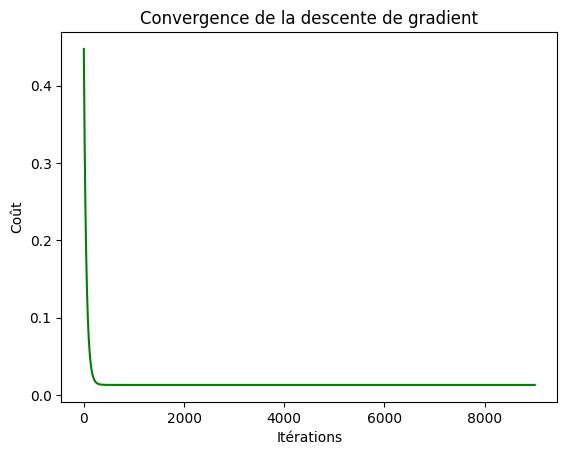

In [2]:
# Génération des données
np.random.seed(42)
n_samples = 500

# Feature1 : Surface en m²
surface_area = np.random.rand(n_samples) * 2000  # Surfaces comprises entre 0 et 200 m²

# Génération d'un prix basé sur une relation polynomiale de degré 4
prices = (
    5000
    + 10 * surface_area 
)

# Ajout d'un peu de bruit supplémentaire
noise = np.random.randn(n_samples) * 1000  # Bruit de plus petite amplitude
prices += noise  # Ajouter le bruit supplémentaire aux prix

# Ajout d'outliers
outliers_index = np.random.choice(np.arange(n_samples), size=5, replace=False)
outlier_values = np.random.choice([-500, 500], size=5)  # Choisir des valeurs d'outliers aléatoires (positives ou négatives)
prices[outliers_index] += outlier_values  # Ajouter ou soustraire des valeurs extrêmes aux prix

# Création d'un DataFrame pour organiser les données
data = pd.DataFrame({
    'Feature1': surface_area,  # Surface en m²
    'Target': prices           # Prix en MAD
})


# ==============================
# 📌 INITIALISATION DES VARIABLES X ET y
# ==============================
features = ['Feature1']
target = 'Target'

X = data[features].values  # Variables explicatives
y = data[target].values.reshape(-1, 1)  # Variable cible

# Création du modèle de régression
degree=1
model = Regression(learning_rate=0.01, degree=degree,test_size=0.3, iterations=9000)

# Entraînement du modèle
cost_history = model.fit(X, y)

# Récupération des paramètres
theta = model.get_parameters()
if degree == 1:
    print(f"Paramètres appris (theta): \n")
    print(f"Theta0 = {theta[0][0]}")
    print(f"Theta1 = {theta[1][0]}")
else:
    print(f"Paramètres appris (theta):{theta} \n")
# Tracé de la courbe de coût
plt.plot(range(len(cost_history)), cost_history, color='green')
plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Convergence de la descente de gradient')
plt.show()

test:

Évaluation du mymodel:
MSE = 1445632.312633135
MAE = 1012.52743395115
R² = 0.9600110267442503
Paramètres appris (theta): 

Theta0 = 4837.62789954608
Theta1 = 10.185412654530554


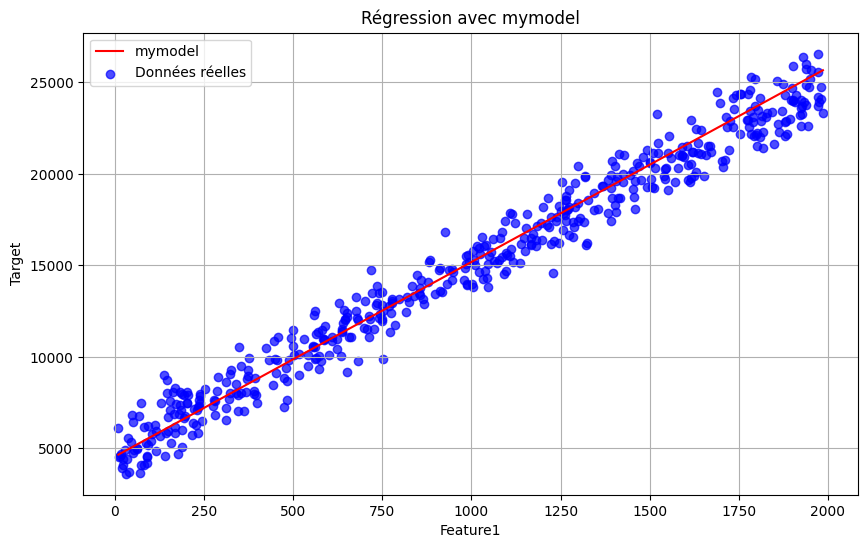

Évaluation du modèle polynomial:
MSE=: 1048214.9399616229
R²: 0.9710043564784097
Paramètres appris (theta): 

Theta0 = 4837.627899546031
Theta1 = 10.185412654530605


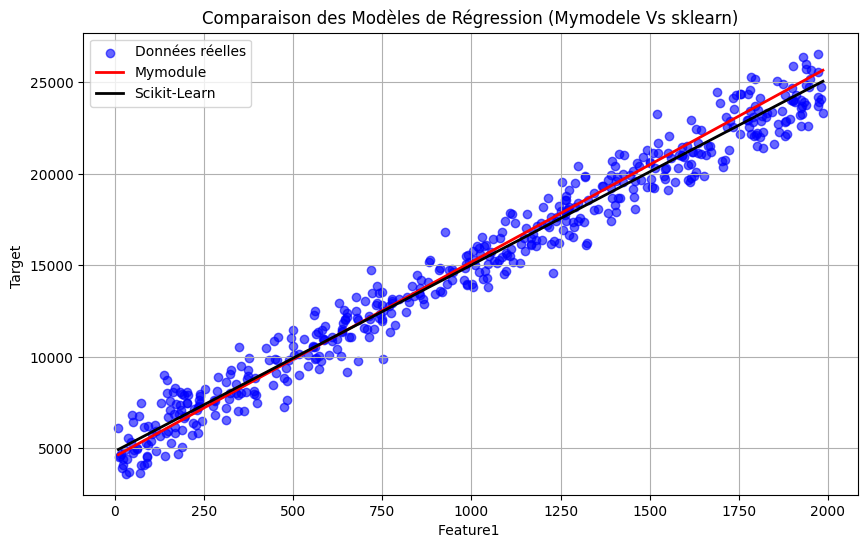

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(model.X_test)
# Evaluation
print("test:\n")
model.evaluate( model.y_test , y_pred)
# Récupération des paramètres
theta = model.get_parameters()
print(f"Paramètres appris (theta): \n")
print(f"Theta0 = {theta[0][0]}")
print(f"Theta1 = {theta[1][0]}")
# Créer un vecteur p pour l'axe x avec une plage linéaire de Feature1
p = np.linspace(X[:, 0].min(), X[:, 0].max(), X.shape[0]).reshape(-1, 1)  # Redimensionner p en 2D

# Faire les prédictions pour les nouvelles valeurs de Feature1
y_pred = model.predict(p)  # Prédictions du modèle

# Tracer la courbe des prédictions
plt.figure(figsize=(10, 6))
plt.plot(p, y_pred, color='red', label='mymodel')  # Courbe des prédictions
plt.scatter(X[:, 0], y, color='blue', label='Données réelles', alpha=0.7)  # Données réelles
plt.xlabel('Feature1')
plt.ylabel('Target')
plt.title('Régression avec mymodel')
plt.legend()
plt.grid(True)
plt.show()
# ==============================
# 🔍 MODÈLE SCIKIT-LEARN (model1)
# ==============================
# Entraînement d'un modèle de régression linéaire avec Scikit-Learn
model1 = LinearRegression()
model1.fit(model.X_train, model.y_train)

# Prédictions de Scikit-Learn
y_pred_sklearn = model1.predict(model.X_test)
# Evaluation du modèle personnalisé avec scikit-learn (calcul de MSE et R²)
mse_custom = mean_squared_error(model.y_test, y_pred_sklearn)
r2_custom = r2_score(model.y_test, y_pred_sklearn)

#
print(f"Évaluation du modèle polynomial:")
print(f"MSE=: {mse_custom}")
print(f"R²: {r2_custom}")

# Récupération des paramètres
theta=model1.intercept_[0],model1.coef_[0][0]
print(f"Paramètres appris (theta): \n")
print(f"Theta0 = {theta[0]}")
print(f"Theta1 = {theta[1]}")

# 📈 COMPARAISON DES PRÉDICTIONS
# ==============================
y_pred_sklearn = model1.predict(p)  # Prédictions du modèle
plt.figure(figsize=(10, 6))

# Données réelles
plt.scatter(X, y, color='blue', label='Données réelles', alpha=0.6)

# Courbe du modèle Mymodel 
if 'y_pred' in locals():
    plt.plot(p, y_pred, color='red', label='Mymodule', linewidth=2)

# Courbe du modèle Scikit-Learn (en rouge pointillée)
plt.plot(p, y_pred_sklearn, 'k', label='Scikit-Learn', linewidth=2)

# Personnalisation du graphique
plt.xlabel('Feature1 ')
plt.ylabel('Target ')
plt.title('Comparaison des Modèles de Régression (Mymodele Vs sklearn)')
plt.legend()
plt.grid(True)

# Affichage
plt.show()